# **Machine Learning: Project 2 - Road segmentation**

---

## Drive/repository access

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
## Folder path to Google Drive project directory

victor = False
tomas = True
edwin = False

if tomas:
  path_to_your_folder =  "/content/drive/MyDrive/ML_google_colab/Project 2/submission_branch/ml-project-2-roadmen-bruv"
elif victor:
  path_to_your_folder = "/content/drive/MyDrive/EPFL/MachineLearningMA3/ml-project-2-roadmen-bruv"
elif edwin:
  path_to_your_folder = "/content/drive/MyDrive/ml-project-2-roadmen-bruv"


%cd $path_to_your_folder

/content/drive/MyDrive/ML_google_colab/Project 2/submission_branch/ml-project-2-roadmen-bruv


## Libraries installation and imports

In [ ]:
from IPython.display import clear_output
!pip install git+https://github.com/qubvel/segmentation_models.pytorch --quiet
!pip install -U albumentations --quiet
clear_output()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
import albumentations as albu

import sys
sys.path.append("./utils")
sys.path.append("./helpers")

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pandas as pd

## Utils
from save_training_results import save_results
from data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset, augment_data
from dataset import Dataset, get_preprocessing

## Helpers
from mask_to_submission import masks_to_submission


## To empty cache
import gc ###
gc.collect()
torch.cuda.empty_cache()






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Augment the data (only needs to be done once)

In [ ]:
# Create folders for data augmentation and store augmented data
augment_data()

Directory data/data_train_augmented created
Directory data/data_train_augmented/images/ created
Directory data/data_train_augmented/masks/ created
Directory data/data_train_augmented/raw/ created
Directory data/data_train_augmented/raw/images/ created
Directory data/data_train_augmented/raw/masks/ created
Directory data/data_validation created
Directory data/data_validation/images/ created
Directory data/data_validation/masks/ created
Directory data/data_validation/raw/ created
Directory data/data_validation/raw/images/ created
Directory data/data_validation/raw/masks/ created
Images stored in ./data/data_train_augmented/raw/images/
Images stored in ./data/data_train_augmented/raw/masks/
Images stored in ./data/data_validation/raw/images/
Images stored in ./data/data_validation/raw/masks/
Images stored in ./data/data_validation/images/
Images stored in ./data/data_validation/masks/
Images stored in ./data/data_train_augmented/images/
Images stored in ./data/data_train_augmented/masks/


## Command board

In [ ]:
PARAMS = {
  'MODELS' : ["Unet"], # Available : "Unet","DeepLabV3","FPN", "UnetPlusPlus"
  'ENCODER' : 'resnet34',
  'ENCODER_WEIGHTS' : 'imagenet',
  'NB_EPOCHS' : 15,
  'ACTIVATION' : 'sigmoid', # could be None for logits or 'softmax2d' for multiclass segmentation,
  'DATA_AUGMENTATION' : False, #choose whether to train with augmented dataset,
  'LOSS_TYPE': "tversky", # Possible: ["dice", "tversky", "custom"]
  'METRIC_TYPE': "fscore", # Possible: ["custom", "fscore"]
  'THRESHOLD' : 0.5,  # Threshold for determining foreground vs background
  'CLASSES' : ['road'],
  'AVERAGE' : True,  # Each image is predicted 4 times (once in each orientation) and the average of those predictions is used as the AICrowd submission
  'SUBMISSION_MODEL' : "Unet", #Choose which model will be used to generate the aicrowd submission
}

TVERSKY = {
    'alpha' : 0.3,
    'beta' : 0.3,
    'gamma' : 0.75,
}

In [ ]:

#Creates the necessary folders for saving results
model_weights_folder = './submissions/models/'
os.makedirs(model_weights_folder, exist_ok=True)

# Parameters for saving images
submission_folder = './submissions/'
os.makedirs(submission_folder, exist_ok=True)

pr_masks_folder = submission_folder + 'predicted_masks/'
os.makedirs(pr_masks_folder, exist_ok=True)

## Creating training and validation set

In [ ]:
## Importing preprocessing fonction
preprocessing_fn = smp.encoders.get_preprocessing_fn(PARAMS["ENCODER"], PARAMS["ENCODER_WEIGHTS"])

#Defining folder paths
PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"
PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
PATH_VAL_IMG = "./data/data_validation/images/"
PATH_VAL_MASK = "./data/data_validation/masks/"


#change paths for the training and validation datasets depending on wether we want data augmentation or not
if PARAMS["DATA_AUGMENTATION"]:
  training_path_img = PATH_TR_IMG_AUG
  training_path_mask = PATH_TR_MASK_AUG
  validation_path_img = PATH_VAL_IMG
  validation_path_mask = PATH_VAL_MASK
else:
  training_path_img = PATH_TR_IMG_AUG_RAW
  training_path_mask = PATH_TR_MASK_AUG_RAW
  validation_path_img = PATH_VAL_IMG_RAW
  validation_path_mask = PATH_VAL_MASK_RAW

#create training and validation datasets
train_dataset = Dataset(
    training_path_img,
    training_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"])


valid_dataset = Dataset(
    validation_path_img,
    validation_path_mask,
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

#create the loaders for both datasets
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=False)



### Patch based Loss and evaluation metrics


In [ ]:
from f1scorepatch import F1ScorePatch

# select the loss type
if PARAMS["LOSS_TYPE"] == "dice":
  loss_fn = smp.losses.dice.DiceLoss(mode ='binary')
  loss_fn.__name__ = 'Dice_loss'
  loss_name = 'Dice_loss'
elif PARAMS["LOSS_TYPE"] == "tversky":
  loss_fn = smp.losses.tversky.TverskyLoss(mode ='binary', alpha=TVERSKY["alpha"] , beta=TVERSKY["beta"], gamma=TVERSKY["gamma"])
  loss_fn.__name__ = 'Tversky_Loss'
  loss_name = 'Tversky_Loss'

# select the metric type
if PARAMS["METRIC_TYPE"] == "fscore":
  metrics_training = [smp_utils.metrics.Fscore()]
  metrics_validation = [smp_utils.metrics.Fscore(), F1ScorePatch(activation='sigmoid')]
  metric_name_val = "f1_score_patch" # can also pick "fscore"

## Training

In [ ]:
#Instantiating all the models
models = [[smp.create_model(model_name, encoder_name=PARAMS["ENCODER"], encoder_weights = PARAMS["ENCODER_WEIGHTS"], in_channels=3, classes=1),model_name] for model_name in PARAMS["MODELS"]]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 273MB/s]


Unet

Epoch: 0
valid: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it, Tversky_Loss - 0.6932, fscore - 0.008219, f1_score_patch - 0.06169]
dict_items([('Tversky_Loss', 0.6932409405708313), ('fscore', 0.008218859322369099), ('f1_score_patch', 0.06168585643172264)])
{'Tversky_Loss': 0.6932409405708313, 'fscore': 0.008218859322369099, 'f1_score_patch': 0.06168585643172264}
Model saved!

Epoch: 1
valid: 100%|██████████| 1/1 [00:05<00:00,  5.47s/it, Tversky_Loss - 0.3835, fscore - 0.2043, f1_score_patch - 0.8186]
dict_items([('Tversky_Loss', 0.3834832012653351), ('fscore', 0.2042970359325409), ('f1_score_patch', 0.8186129331588745)])
{'Tversky_Loss': 0.3834832012653351, 'fscore': 0.2042970359325409, 'f1_score_patch': 0.8186129331588745}
Model saved!

Epoch: 2
valid: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it, Tversky_Loss - 0.4008, fscore - 0.2131, f1_score_patch - 0.7381]
dict_items([('Tversky_Loss', 0.4007991850376129), ('fscore', 0.21308647096157074), ('f1_score_patch', 0.7381041646003723

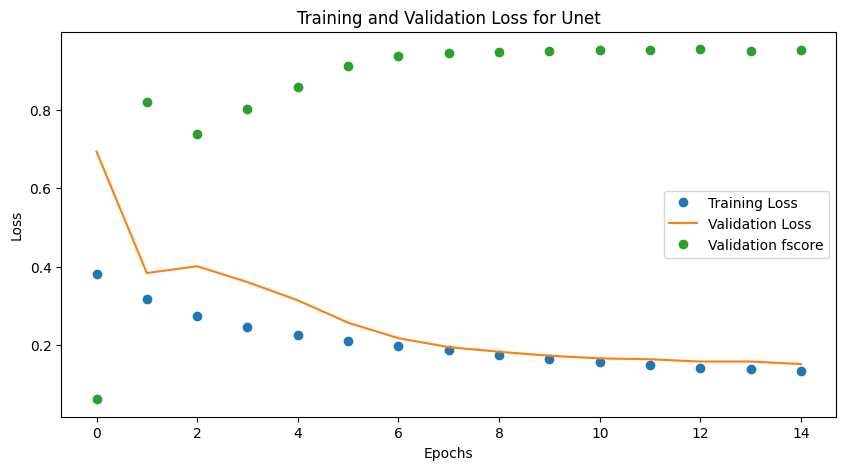

In [ ]:
# train models for NB_EPOCHS

for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=4.559e-4),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss_fn,
      metrics=metrics_training,
      optimizer=optimizer,
      device="cuda",
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss_fn,
      metrics= metrics_validation,
      device="cuda",
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []

  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

  for i in range(0, PARAMS["NB_EPOCHS"]):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)
      print(valid_logs.items())
      train_loss_array.append(train_logs[loss_name])
      validation_loss_array.append(valid_logs[loss_name])
      validation_fscore_array.append(valid_logs[metric_name_val])
      print(valid_logs)

      scheduler.step(valid_logs[metric_name_val])

      # only saving the model if the validation metric increases
      if max_score < valid_logs[metric_name_val]:
          max_score = valid_logs[metric_name_val]
          torch.save(model, model_weights_folder + 'best_model_{}.pth'.format(model_name))
          print('Model saved!')


  epochs = range(0,len(train_loss_array))
  save_results(PARAMS,train_loss_array,validation_loss_array,validation_fscore_array)

# plot the results of the training
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_array,"o", label='Training Loss')
plt.plot(epochs, validation_loss_array,  label='Validation Loss')
plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
plt.title('Training and Validation Loss for {}'.format(model_name))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()





## Load trained model
---



In [ ]:
MODEL_NAME = PARAMS["SUBMISSION_MODEL"]
MODEL_PATH = model_weights_folder + f'best_model_{MODEL_NAME}.pth'
DEVICE ='cuda'
test_model = torch.load(MODEL_PATH)


In [ ]:
#dataset used for predictions
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

## Generate predictions

In [ ]:

### with average of multiple predictions
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)


# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        n, c, h, w = input_tensor.size()
        sum = torch.zeros((n, 1, h, w), device='cuda')
        if PARAMS["AVERAGE"]:
          for i in range(4):
            img_rot = torch.rot90(input_tensor, i%4, [2, 3])
            prediction = test_model(img_rot)
            prediction = torch.rot90(prediction, 4-(i%4), [2, 3]) #rotation back
            sum += prediction
          pred = sum / 4
        else:
          pred = test_model(input_tensor)


        pred_np = pred.detach().cpu().numpy()[0, 0]
        pred_np = 1 / (1 + np.exp(-pred_np))
        pred_voting = (pred_np < 0.5).astype(float)*255

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "pr_img_" + '%.3d' % image_num + '.png'


        cv2.imwrite(os.path.join(pr_masks_folder, filename),pred_voting)

## Visualise predictions

In [ ]:
def list_files_in_directory(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list


pred_files = list_files_in_directory(pr_masks_folder)
pred_files = sorted(pred_files, key=lambda x: int(os.path.basename(x)[7:-4]))

#could sort pred files and images files
img_path = "./data/test_set_images/"
img_files = list_files_in_directory(img_path)
img_files = sorted(img_files, key=lambda x: int(os.path.basename(x)[5:-4]))
img_mask_list = []
for i, pred_file in enumerate(pred_files):
    img = cv2.imread(img_files[i], cv2.IMREAD_COLOR)
    pred_mask = cv2.imread(pred_file, cv2.IMREAD_GRAYSCALE)

    # Create a semi-transparent green mask
    alpha = 0.7
    red_mask = np.zeros_like(img)
    for (i,j), value in np.ndenumerate(pred_mask):
        if value == 255:
            red_mask[i,j] = [0, 255, 0]

    # Combine image and the green mask
    result = cv2.addWeighted(img, 1, red_mask, alpha, 0)
    img_mask_list.append(result)
# Set the number of images per row
images_per_row = 5

# Calculate the number of rows needed
num_rows = (len(img_mask_list) + images_per_row - 1) // images_per_row

# Create a single row of subplots
fig, axs = plt.subplots(1, images_per_row, figsize=(10, 5))

# Loop through files and plot images
for i, img in enumerate(img_mask_list):
    axs[i % images_per_row].imshow(img)
    axs[i % images_per_row].axis('off')

    # If last image in the row, create a new row of subplots
    if (i + 1) % images_per_row == 0:
        plt.show()
        if i + 1 < len(img_mask_list):
            fig, axs = plt.subplots(1, images_per_row, figsize=(10, 5))

plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Submission

In [ ]:
submission_filename = submission_folder + '{}.csv'.format(MODEL_NAME)
image_filenames = []
for i in range(1, 51):
    image_filename = pr_masks_folder + 'pr_img_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)
